# Flow inside a pipe (2D)
This notebook implements a steady incompressible Navier-Stokes solver for the flow inside a tube.

The problem is strong form reads:
\begin{equation}
\left\{
\begin{array}{ll}
    \nabla \cdot \mathbf{u} =0& in\;\Omega\\
    \displaystyle \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}= \nu\Delta \mathbf{u}-\nabla p & in\;\Omega\\ & \\
    \mathbf{u} = \mathbf{i} & on\;\Gamma_{in}\\
    \mathbf{u} = \mathbf{0} & on\;\Gamma_w\\
    \mathbf{u}\cdot \mathbf{n} = \mathbf{0} & on\;\Gamma_{sym}\\
    \left(\frac{1}{Re}\nabla \mathbf{u}-p\mathbb{I}\right)\cdot \mathbf{n}=\mathbf{0} & on \;\Gamma_{out}
\end{array}
\right.
\end{equation}

In [1]:
import tqdm
import numpy as np

# Mesh generation
import dolfinx
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.io import gmshio, XDMFFile
from dolfinx import fem
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_topological, form, assemble_scalar
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot
from petsc4py import PETSc

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

The problem we want to face is non-linear, whose weak formulation reads:
\begin{equation}
\int_\Omega \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}\cdot \mathbf{v}\,d\Omega + \nu \int_\Omega\nabla \mathbf{u}\cdot \nabla \mathbf{v}\,d\Omega -\int_\Omega p(\nabla\cdot\mathbf{v})\,d\Omega -\int_\Omega q(\nabla\cdot\mathbf{u})\,d\Omega=0
\end{equation}

Let us solve the problem considering a $Re = 20$.

In [2]:
class BoundaryVelocity():
    def __init__(self, u_in, gdim):
        self.u_in = u_in
        self.gdim = gdim

    def __call__(self, x):
        values = np.zeros((self.gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = self.u_in
        return values


class unsteadyNS():
    def __init__(self, meshFile, gdim, inl_marker, bottom_marker, top_marker, out_marker):

        # Domain
        self.domain, _, self.ft = gmshio.read_from_msh(meshFile+".msh", MPI.COMM_WORLD, gdim = gdim)
        self.gdim = gdim
        self.fdim = gdim - 1
        
        # Assign markers
        self.inl_marker = inl_marker
        self.bottom_marker = bottom_marker
        self.top_marker = top_marker
        self.out_marker = out_marker

        self.ds = ufl.Measure('ds', domain=self.domain, subdomain_data=self.ft)
        self.L = self.domain.comm.allreduce(assemble_scalar(form(1.0 * self.ds(self.top_marker))), op=MPI.SUM)
        self.R = self.domain.comm.allreduce(assemble_scalar(form(1.0 * self.ds(self.inl_marker))),  op=MPI.SUM)

        # Functional Spaces
        self.P2 = ufl.VectorElement("Lagrange", self.domain.ufl_cell(), 2)
        self.P1 = ufl.FiniteElement("Lagrange", self.domain.ufl_cell(), 1)
        self.mixEl = ufl.MixedElement(self.P2, self.P1)
        self.W = FunctionSpace(self.domain, self.mixEl)

        # Test and trial functions: monolithic
        (self.v, self.q) = ufl.TestFunctions(self.W)
        self.dup = ufl.TrialFunction(self.W)
        self.up  = fem.Function(self.W)
        (self.u, self.p) = ufl.split(self.up)

    def parameters(self, u_in, Re):

        # Computing the viscosity
        self.nuValue = u_in * self.R / Re
        print('Re = {:.0f}'.format(Re)+', u_in = {:.2f}'.format(u_in) +' [cm/s] and nu = {:.2e}'.format(self.nuValue)+' [cm2/s]')
        self.nu = fem.Constant(self.domain, PETSc.ScalarType(self.nuValue))

        # Setting Boundary Conditions
        self.inlet_velocity = BoundaryVelocity(u_in, self.gdim)
        self.in_velocity = Function(self.W.sub(0).collapse()[0])
        self.in_velocity.interpolate(self.inlet_velocity)
        self.bc_in = dirichletbc(self.in_velocity, 
                                 locate_dofs_topological((self.W.sub(0), self.W.sub(0).collapse()[0]), 
                                                        self.fdim, self.ft.find(self.inl_marker)),
                                 self.W.sub(0))

        self.zero_velocity = BoundaryVelocity(0., self.gdim)
        self.u_noslip = Function(self.W.sub(0).collapse()[0])
        self.u_noslip.interpolate(self.zero_velocity)
        self.bc_w = dirichletbc(self.u_noslip, 
                                locate_dofs_topological((self.W.sub(0), self.W.sub(0).collapse()[0]), 
                                                        self.fdim, self.ft.find(self.bottom_marker)),
                                 self.W.sub(0))

        self.bc_sym = dirichletbc(self.u_noslip.sub(1), 
                                locate_dofs_topological((self.W.sub(0).sub(1), self.W.sub(0).sub(1).collapse()[0]), 
                                                         self.fdim, self.ft.find(self.top_marker)),
                                 self.W.sub(0).sub(1))

        self.bcs = [self.bc_w, self.bc_in, self.bc_sym]

    def create_snes_solution(self) -> PETSc.Vec:  # type: ignore[no-any-unimported]
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: PETSc.Vec) -> None:  # type: ignore[no-any-unimported]
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x
            
    def obj_fun(self, snes: PETSc.SNES, x: PETSc.Vec) -> np.float64:
            """Compute the norm of the residual."""
            self.F_fun(snes, x, self._obj_vec)
            return self.b.norm()  # type: ignore[no-any-return]

    def F_fun(self, snes: PETSc.SNES, x: PETSc.Vec, F_vec: PETSc.Vec) -> None:
            """Assemble the residual."""
            self.update_solution(x)
            with F_vec.localForm() as F_vec_local:
                F_vec_local.set(0.0)
            fem.petsc.assemble_vector(F_vec, self._F)
            dolfinx.fem.apply_lifting(F_vec, [self._J], [self.bcs], x0=[x], scale=-1.0)
            F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
            fem.set_bc(F_vec, self.bcs, x, -1.0)

    def J_fun( self, snes: PETSc.SNES, x: PETSc.Vec, J_mat: PETSc.Mat, P_mat: PETSc.Mat) -> None:
            """Assemble the jacobian."""
            J_mat.zeroEntries()
            fem.petsc.assemble_matrix(J_mat, self._J, self.bcs, diagonal=1.0)
            J_mat.assemble()

    def assemble(self, maxIter):

        # Variational forms
        self.F = (self.nu * inner(grad(self.u), grad(self.v)) * ufl.dx
                + inner(grad(self.u) * self.u, self.v) * ufl.dx
                - inner(self.p, ufl.div(self.v)) * ufl.dx
                + inner(div(self.u), self.q) * ufl.dx)
        self.J = ufl.derivative(self.F, self.up, self.dup)

        self._F = form(self.F)
        self._J = form(self.J)

        # Create matrix and vector
        self._solution = self.up
        self._obj_vec = fem.petsc.create_vector(self._F)
        self.b = fem.petsc.create_vector(self._F)
        self.A = fem.petsc.create_matrix(self._J)

        # Solver settings
        self.solver = PETSc.SNES().create(self.domain.comm)
        self.solver.setTolerances(max_it=maxIter)
        self.solver.getKSP().setType("preonly")
        self.solver.getKSP().getPC().setType("lu")
        self.solver.getKSP().getPC().setFactorSolverType("mumps")

        self.solver.setObjective(self.obj_fun)
        self.solver.setFunction(self.F_fun, self.b)
        self.solver.setJacobian(self.J_fun, J=self.A, P=None)
        self.solver.setMonitor(lambda _, it, residual: print(it, residual))

    def solve(self):
        up_copy = self.create_snes_solution()
        self.solver.solve(None, up_copy)
        self.update_solution(up_copy)
        return self._solution

Let's solve the problem

In [3]:
gdim = 2
inl_marker  = 10
bottom_marker = 20
top_marker = 30
out_marker  = 40
velocityProblem = unsteadyNS('channel2D', gdim, inl_marker, bottom_marker, top_marker, out_marker)

Info    : Reading 'channel2D.msh'...
Info    : 9 entities
Info    : 20000 nodes
Info    : 21017 elements
Info    : Done reading 'channel2D.msh'


Let us define a function to plot the solution on the middle of the channel

In [4]:
def extract1D(NS, x_grid, Ny, u_sol):
    clad_or = 1.88
    y_grid = np.linspace(clad_or, NS.R+clad_or, Ny)

    points = np.zeros((3, Ny))
    points[0, :] = x_grid
    points[1, :] = y_grid

    bb_tree = dolfinx.geometry.BoundingBoxTree(NS.domain, NS.domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(NS.domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    ux = u_sol.sub(0).eval(xPlot, cells).flatten()
    uy = u_sol.sub(1).eval(xPlot, cells).flatten()
    return ux, uy, y_grid

Now we can solve the problem for different values of the Reynolds number

In [5]:
u_in = 10.
ReVec = np.array([20, 500, 1000, 2000, 4000])

ux_Middle = []
uy_Middle = []
yPlot = []

x_grid = 0.

for ii in range(len(ReVec)):
    print(' ')

    Re = ReVec[ii]
    velocityProblem.parameters(u_in, Re)

    velocityProblem.assemble(20)
    up_sol = velocityProblem.solve()
    (u_m, p_m) = (up_sol.sub(0).collapse(), up_sol.sub(1).collapse())
    
    ux_, uy_, y_ = extract1D(velocityProblem, x_grid, 50, u_m)

    ux_Middle.append(ux_)
    uy_Middle.append(uy_)
    yPlot.append(y_)

    # u_xdmf = XDMFFile(velocityProblem.domain.comm, "U_"+str(Re)+".xdmf", "w")
    # u_xdmf.write_mesh(velocityProblem.domain)
    # u_m.name = "U"
    # u_xdmf.write_function(u_m)
    # u_xdmf.close()

    # u_xdmf = XDMFFile(velocityProblem.domain.comm, "p_"+str(Re)+".xdmf", "w")
    # u_xdmf.write_mesh(velocityProblem.domain)
    # p_m.name = "p"
    # u_xdmf.write_function(p_m)
    # u_xdmf.close()

 
Re = 20, u_in = 10.00 [cm/s] and nu = 1.50e-01 [cm2/s]
0 62.559520747570666
1 1.2429122404440234
2 0.10564716810654358
3 0.00010319113944184018
4 9.454682339188215e-11
 
Re = 500, u_in = 10.00 [cm/s] and nu = 6.00e-03 [cm2/s]
0 4.388378011081734
1 0.5906088106410139
2 0.060797533313571954
3 0.001232309945985516
4 3.3875115576184435e-07
5 1.636373979987415e-13
 
Re = 1000, u_in = 10.00 [cm/s] and nu = 3.00e-03 [cm2/s]
0 0.15837568748608363
1 0.031313783436530865
2 0.0005667151752852293
3 1.7761279083201322e-07
4 8.767134108887439e-14
 
Re = 2000, u_in = 10.00 [cm/s] and nu = 1.50e-03 [cm2/s]
0 0.10311278665041264
1 0.030428057438653178
2 0.0006307065498613288
3 3.5136059294545677e-07
4 1.0775122282194711e-13
 
Re = 4000, u_in = 10.00 [cm/s] and nu = 7.50e-04 [cm2/s]
0 0.07295265742645865
1 0.033977306405697516
2 0.001676075352351974
3 1.4040074949325244e-05
4 1.2876280892992858e-09
5 4.075511701362265e-14


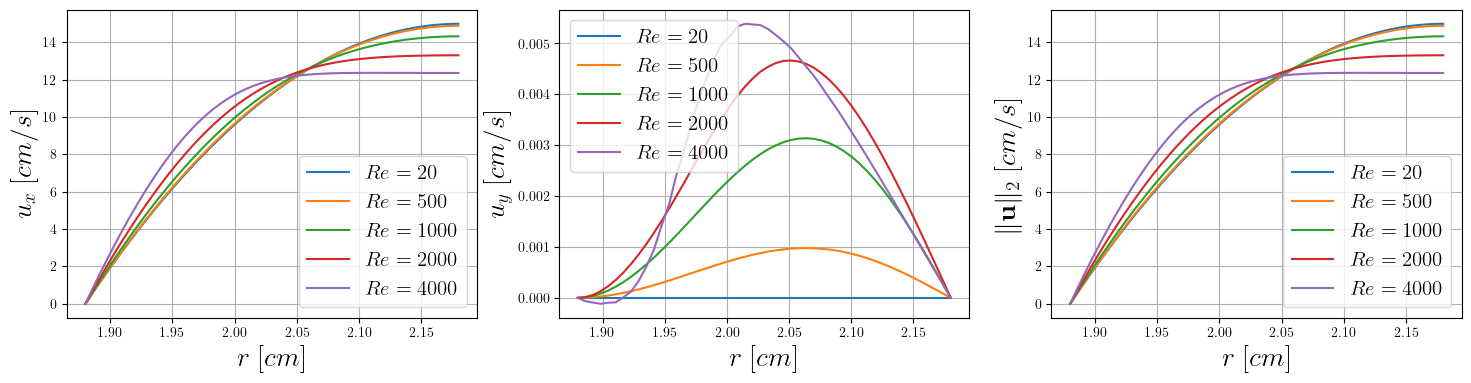

In [6]:
fig = plt.figure( figsize = (18,4) )

plt.subplot(1,3,1)
for ii in range(len(ux_Middle)):
    plt.plot(yPlot[ii], ux_Middle[ii], label = r'$Re = {:.0f}'.format(ReVec[ii])+'$')
plt.xlabel(r'$r\;[cm]$', fontsize = 20)
plt.ylabel(r'$u_x\;[cm/s]$', fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(1,3,2)
for ii in range(len(ux_Middle)):
    plt.plot(yPlot[ii], uy_Middle[ii], label = r'$Re = {:.0f}'.format(ReVec[ii])+'$')
plt.xlabel(r'$r\;[cm]$', fontsize = 20)
plt.ylabel(r'$u_y\;[cm/s]$', fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(1,3,3)
for ii in range(len(ux_Middle)):
    plt.plot(yPlot[ii], np.sqrt(ux_Middle[ii]**2+uy_Middle[ii]**2), label = r'$Re = {:.0f}'.format(ReVec[ii])+'$')
plt.xlabel(r'$r\;[cm]$', fontsize = 20)
plt.ylabel(r'$\|\mathbf{u}\|_2\;[cm/s]$', fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
#fig.savefig('U_midChannelProfile.pdf', format='pdf', dpi=600, bbox_inches='tight')